In this mission, we're going to build on those foundational principles, and learn:

Several new regex syntax components to allow us to express more complex criteria.

- How to combine regular expression patterns to extract and transform data.
- How to replace and clean data using regular expressions.
-
We're going to continue working with the dataset from the previous mission from technology site Hacker News. Let's take a moment to refresh our memory of the different columns in this dataset:

- id: The unique identifier from Hacker News for the story
- title: The title of the story
- url: The URL that the stories links to, if the story has a URL
- num_points: The number of points the story acquired, calculated as the total number of upvotes minus the total number of downvotes
- num_comments: The number of comments that were made on the story
- author: The username of the person who submitted the story
- created_at: The date and time at which the story was submitted

We'll continue to analyze and count mentions of different programming languages in the dataset, and then we'll finish by extracting the different components of the URLs submitted to Hacker News.

As we mentioned in the previous mission, you shouldn't expect to remember every single detail of regular expression syntax. The most important thing is to understand the core principles, what is possible, and where to look up the details. This will mean you can quickly jog your memory whenever you need regular expressions.

We'll be building on the foundational concepts that we learned in the previous mission. If you need to refresh any points of the syntax while you complete exercises in this mission, we recommend using a regex syntax reference like RegExr so you can practice looking up syntax as you need it.

Let's start by reading in the dataset using pandas and extracting the story titles from the title column:

In [4]:
import pandas as pd
import re

hn = pd.read_csv("hacker_news.csv")
titles = hn['title']

In the story titles, we have two different capitalizations for the Python language: Python and python. In the previous mission, we learned two techniques for handling cases like these. The first is to use a set to match either P or p:

In [2]:
pattern = r"[Pp]ython"
python_counts = titles.str.contains(pattern).sum()
print(python_counts)

160


The second option we learned is to use re.I — the ignorecase flag — to make our pattern case insensitive:

In [5]:
pattern = r"python"
python_counts = titles.str.contains(pattern, flags=re.I).sum()
print(python_counts)

160


The ignorecase flag is particularly useful when we have many different capitalizations for a word or phrase. In our dataset, the SQL language has three different capitalizations: SQL, sql, and Sql.

To use sets to capture all of these variations, we would need to use a set for each character:

In [6]:
pattern = r"[Ss][Qq][Ll]"
sql_counts = titles.str.contains(pattern).sum()
print(sql_counts)

108


Instead, let's use the ignorecase flag to write a case-insensitive version of this regular expression.

In [7]:
sql_counts = titles.str.contains(r'sql', flags = re.I).sum()
sql_counts

108

### Capture groups

Let's look at how we can use a capture group to create a frequency table of the different capitalizations of SQL in our dataset. We start by wrapping our regex pattern in parentheses:

In [8]:
pattern = r"(SQL)"

Next, we use Series.str.extract() to extract the different capitalizations:

In [9]:
sql_capitalizations = titles.str.extract(pattern, flags=re.I)

Lastly, we use the Series.value_counts() method to create a frequency table of those capitalizations:

In [10]:
sql_capitalizations_freq = sql_capitalizations.value_counts()
print(sql_capitalizations_freq)

SQL    101
Sql      4
sql      3
dtype: int64


We can extend this analysis by looking at titles that have letters immediately before the "SQL," which is a convention often used to denote different variations or flavors of SQL:

In [11]:
pattern = r"(\w+SQL)"
sql_flavors = titles.str.extract(pattern, flags=re.I)
sql_flavors_freq = sql_flavors.value_counts()
print(sql_flavors_freq)

PostgreSQL    27
NoSQL         16
MySQL         12
CloudSQL       1
MemSQL         1
SparkSQL       1
mySql          1
nosql          1
dtype: int64


Notice how there is some duplication due to varied capitalization in this frequency table:

- NoSQL and nosql
- MySQL and mysql

In this exercise, we're going to extract the mentions of different SQL flavors into a new column and clean those duplicates by making them all lowercase. We'll then analyze the results to look at the average number of comments for each flavor.

In [13]:
hn_sql = hn[hn['title'].str.contains(r"\w+SQL", flags=re.I)].copy()
hn_sql.head()

,id,title,url,num_points,num_comments,author,created_at
142,10957172,PostgreSQL: Linux VS Windows part 2,http://www.sqig.net/2016/01/postgresql-linux-v...,16,3,based2,1/23/2016 4:21
221,11544342,MemSQL (YC W11) Raises $36M Series C,http://blog.memsql.com/memsql-raises-series-c/,74,14,ericfrenkiel,4/21/2016 18:32
882,10413272,Pgmemcahe :A PostgreSQL memcache functions,https://github.com/ohmu/pgmemcache/,2,1,websec,10/19/2015 14:55
1160,10546681,How to choose an in-memory NoSQL solution: Per...,http://articles.rvncerr.org/how-to-chose-an-in...,9,4,rvncerr,11/11/2015 14:04
1197,11583183,Postgraphql: A GraphQL schema created by refle...,https://github.com/calebmer/postgraphql,217,24,craigkerstiens,4/27/2016 18:29


In [15]:
titles = hn['title']
titles

0                                Interactive Dynamic Video
1        Florida DJs May Face Felony for April Fools' W...
2             Technology ventures: From Idea to Enterprise
3        Note by Note: The Making of Steinway L1037 (2007)
4        Title II kills investment? Comcast and other I...
                               ...                        
20094    How Purism Avoids Intels Active Management Tec...
20095            YC Application Translated and Broken Down
20096    Microkernels are slow and Elvis didn't do no d...
20097                        How Product Hunt really works
20098    RoboBrowser: Your friendly neighborhood web sc...
Name: title, Length: 20099, dtype: object

In [16]:
hn_sql['flavor'] = titles.str.extract(r"(\w+SQL)", flags = re.I)
hn_sql['flavor'].head()

142     PostgreSQL
221         MemSQL
882     PostgreSQL
1160         NoSQL
1197    PostgreSQL
Name: flavor, dtype: object

In [17]:
hn_sql['flavor'] = hn_sql['flavor'].str.lower()
hn_sql['flavor'].head()

142     postgresql
221         memsql
882     postgresql
1160         nosql
1197    postgresql
Name: flavor, dtype: object

In [19]:
sql_pivot = hn_sql.pivot_table(index = 'flavor', values = 'num_comments')
sql_pivot

,num_comments
flavor,
cloudsql,5.000000
memsql,14.000000
mysql,12.230769
nosql,14.529412
postgresql,25.962963
sparksql,1.000000


### Using capture groups to extract data

So far we've used capture groups to extract all or most of the text in our regular expression pattern. Capture groups can also be useful to extract specific data from within our expression.

Let's look at a sample of Hacker News titles that mention Python:

```
Developing a computational pipeline using the asyncio module in Python 3
Python 3 on Google App Engine flexible environment now in beta
Python 3.6 proposal, PEP 525: Asynchronous Generators
How async/await works in Python 3.5.0
Ubuntu Drops Python 2.7 from the Default Install in 16.04
Show HN: First Release of Transcrypt Python3.5 to JavaScript Compiler
```

All of these examples have a number after the word "Python," which indicates a version number. Sometimes a space precedes the number, sometimes it doesn't. We can use the following regular expression to match these cases:

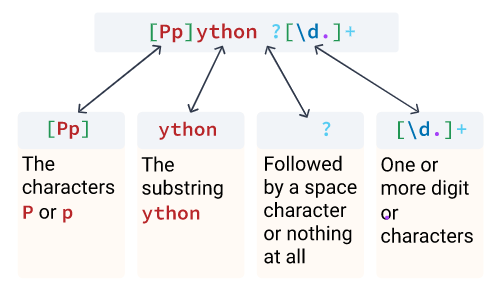

We can use capture groups to extract the version of Python that is mentioned most often in our dataset by wrapping parentheses around the part of our regular expression which captures the version number.

We'll use a capture group to capture the version number after the word "Python," and then build a frequency table of the different versions.

In [20]:
pattern = r'[Pp]ython ([\d\.]+)'

py_versions = titles.str.extract(pattern).value_counts()
py_versions

3        10
2         3
3.5       3
3.6       2
1.5       1
2.7       1
3.5.0     1
4         1
8         1
dtype: int64

In [21]:
py_versions.to_dict()

{('3',): 10,
 ('2',): 3,
 ('3.5',): 3,
 ('3.6',): 2,
 ('1.5',): 1,
 ('2.7',): 1,
 ('3.5.0',): 1,
 ('4',): 1,
 ('8',): 1}

### Counting mentions of the 'C' language

So far, we've created regular expressions to clean and analyze the number of mentions of the Python, SQL, and Java languages. Next up: counting the mentions of the C language.

We can start with a simple regular expression and then iterate as we find and exclude incorrect matches. Let's start with a simple regex that matches the letter "c" with word boundary anchors on either side:

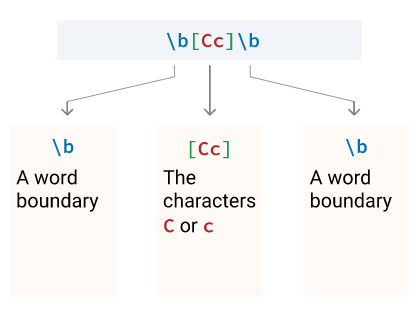

We'll re-use the first_10_matches() function that we defined in the previous mission to see the results we get from this regular expression:

In [22]:
def first_10_matches(pattern):
    """
    Return the first 10 story titles that match
    the provided regular expression
    """
    all_matches = titles[titles.str.contains(pattern)]
    first_10 = all_matches.head(10)
    return first_10

first_10_matches(r"\b[Cc]\b")

13                 Custom Deleters for C++ Smart Pointers
220                        Lisp, C++: Sadness in my heart
221                  MemSQL (YC W11) Raises $36M Series C
353     VW C.E.O. Personally Apologized to President O...
365                      The new C standards are worth it
444           Moz raises $10m Series C from Foundry Group
508     BDE 3.0 (Bloomberg's core C++ library): Open S...
521          Fuchsia: Micro kernel written in C by Google
549     How to Become a C.E.O.? The Quickest Path Is a...
1282    A lightweight C++ signals and slots implementa...
Name: title, dtype: object

Immediately, our results are reasonably relevant. However, we can quickly identify a few match types we want to prevent:

- Mentions of C++, a distinct language from C.
- Cases where the letter C is followed by a period, like in the substring C.E.O.

Let's use a negative set to prevent matches for the + character and the . character.

In [24]:
pattern = r"\b[Cc]\b[^.+]"

first_10_matches(pattern)

365                      The new C standards are worth it
444           Moz raises $10m Series C from Foundry Group
521          Fuchsia: Micro kernel written in C by Google
1307            Show HN: Yupp, yet another C preprocessor
1326                     The C standard formalized in Coq
1365                          GNU C Library 2.23 released
1429    Cysignals: signal handling (SIGINT, SIGSEGV, )...
1620                        SDCC  Small Device C Compiler
1949    Rewriting a Ruby C Extension in Rust: How a Na...
2195    MyHTML  HTML Parser on Pure C with POSIX Threa...
Name: title, dtype: object

### Using lookarounds to control matches based on surrounding text

It looks like we're getting close. In our first 10 matches we have one irrelevant result, which is about "Series C," a term used to represent a particular type of startup fundraising.

Additionally, we've run into the same issue as we did in the previous mission — by using a negative set, we may have eliminated any instances where the last character of the title is "C" (the second last line of output matches in spite of the fact that it ends with "C," because it also has "C" earlier in the string).

Neither of these can be avoided using negative sets, which are used to allow multiple matches for a single character. Instead we'll need a new tool: **lookarounds.**

Lookarounds let us define a character or sequence of characters that either must or must not come before or after our regex match. There are four types of lookarounds:

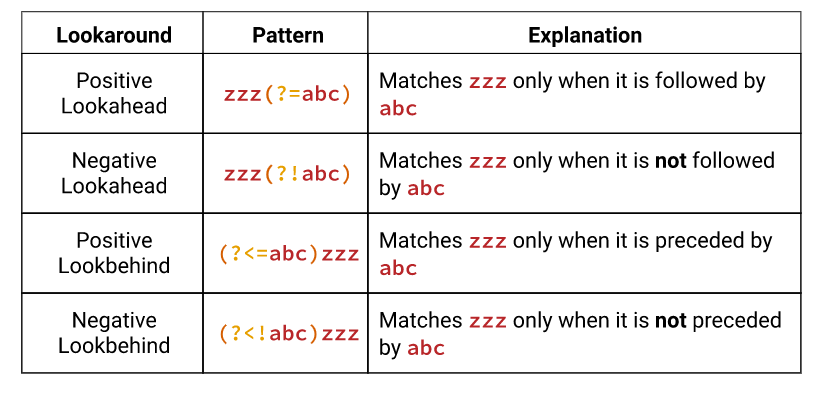

These tips can help you remember the syntax for lookarounds:

- Inside the parentheses, the first character of a lookaround is always `?`.
- If the lookaround is a **lookbehind**, the next character will be `<`, which you can think of as an arrow head pointing behind the match.
- The next character indicates whether the lookaround is positive (`=`) or negative (`!`).

Let's create some test data that we'll use to illustrate how lookarounds work:

In [25]:
test_cases = ['Red_Green_Blue',
              'Yellow_Green_Red',
              'Red_Green_Red',
              'Yellow_Green_Blue',
              'Green']

We'll also create a function that will loop over our test cases and tell us whether our pattern matches. We'll use the re module rather than pandas since it tells us the exact text that matches, which will help us understand how the lookaround is working:

In [26]:
def run_test_cases(pattern):
    for tc in test_cases:
        result = re.search(pattern, tc)
        print(result or "NO MATCH")

In each instance, we'll aim to match the substring Green depending on the characters that precede or follow it. Let's start by using a positive lookahead to include instances where the match is followed by the substring _Blue. We'll include the underscore character in the lookahead, otherwise we will get zero matches

In [27]:
run_test_cases(r"Green(?=_Blue)")

<re.Match object; span=(4, 9), match='Green'>
NO MATCH
NO MATCH
<re.Match object; span=(7, 12), match='Green'>
NO MATCH


Notice how the matches themselves are purely the text Green and don't include the lookahead. Let's look at a negative lookahead to include instances where the match is not followed by the substring _Red:

In [28]:
run_test_cases(r"Green(?!_Red)")

<re.Match object; span=(4, 9), match='Green'>
NO MATCH
NO MATCH
<re.Match object; span=(7, 12), match='Green'>
<re.Match object; span=(0, 5), match='Green'>


Next we'll use a positive lookbehind to include instances where the match is preceded by the substring Red_:

In [29]:
run_test_cases(r"(?<=Red_)Green")

<re.Match object; span=(4, 9), match='Green'>
NO MATCH
<re.Match object; span=(4, 9), match='Green'>
NO MATCH
NO MATCH


And finally, using a negative lookbehind to include instances where the match isn't preceded by the substring Yellow_:

In [31]:
run_test_cases(r"(?<!Yellow_)Green")

<re.Match object; span=(4, 9), match='Green'>
NO MATCH
<re.Match object; span=(4, 9), match='Green'>
NO MATCH
<re.Match object; span=(0, 5), match='Green'>


The contents of a lookaround can include any other regular expression component. For instance, here is an example where we match only cases that are followed by exactly five characters:

In [32]:
run_test_cases(r"Green(?=.{5})")

<re.Match object; span=(4, 9), match='Green'>
NO MATCH
NO MATCH
<re.Match object; span=(7, 12), match='Green'>
NO MATCH


The second and third test cases are followed by four characters, not five, and the last test case isn't followed by anything.

Sometimes programming languages won't implement support for all lookarounds (notably, lookbehinds are not in the official JavaScript specification). As an example, to get full support in the RegExr tool, you'll need to set it to use the PCRE regex engine.

In this exercise, we're going to use lookarounds to refine the regular expression we build on the last screen to capture mentions of the "C" programming language. As a reminder, here is the last of the regular expressions we attempted to use with this exercise earlier, and the resultant titles that match:

In [33]:
first_10_matches(r"\b[Cc]\b[^.+]")

365                      The new C standards are worth it
444           Moz raises $10m Series C from Foundry Group
521          Fuchsia: Micro kernel written in C by Google
1307            Show HN: Yupp, yet another C preprocessor
1326                     The C standard formalized in Coq
1365                          GNU C Library 2.23 released
1429    Cysignals: signal handling (SIGINT, SIGSEGV, )...
1620                        SDCC  Small Device C Compiler
1949    Rewriting a Ruby C Extension in Rust: How a Na...
2195    MyHTML  HTML Parser on Pure C with POSIX Threa...
Name: title, dtype: object

Let's now use lookarounds to exclude the matches we don't want. We want to:

- Keep excluding matches that are followed by . or +, but still match cases where "C" falls at the end of the sentence.
- Exclude matches that have the word 'Series' immediately preceding them.

In [36]:
pattern = r"(?<!Series\s)\b[Cc]\b((?![+.])|\.$)"

c_titles =  titles[titles.str.contains(pattern)]
c_titles

365                       The new C standards are worth it
521           Fuchsia: Micro kernel written in C by Google
1307             Show HN: Yupp, yet another C preprocessor
1326                      The C standard formalized in Coq
1365                           GNU C Library 2.23 released
                               ...                        
18543                 C-style for loops removed from Swift
18549            Show HN: An awesome C library for Windows
18649                 Python vs. C/C++ in embedded systems
19151                      Ask HN: How to learn C in 2016?
19933    Lightweight C library to parse NMEA 0183 sente...
Name: title, Length: 102, dtype: object

In [38]:
c_mentions = titles.str.contains(pattern).sum()
c_mentions

102

### BackReferences: Using capture groups in a RegEx pattern

Let's say we wanted to identify strings that had words with double letters, like the "ee" in "feed." Because we don't know ahead of time what letters might be repeated, we need a way to specify a capture group and then to repeat it. We can do this with backreferences.

Whenever we have one or more capture groups, we can refer to them using integers left to right as shown in this regex that matches the string `HelloGoodbye`:

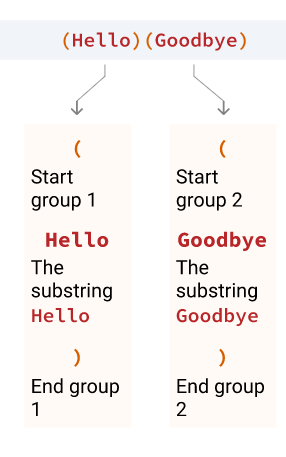


Within a regular expression, we can use a backslash followed by that integer to refer to the group:

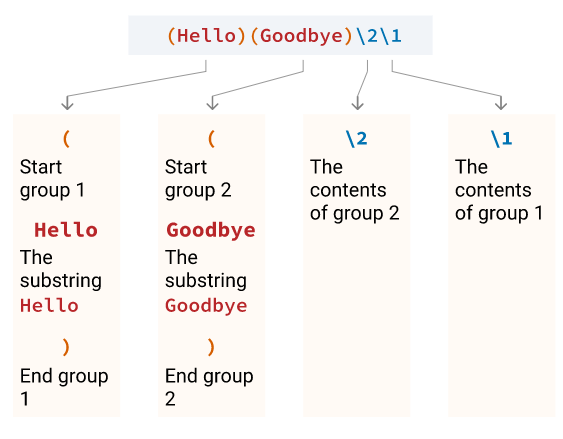

The regular expression above will match the text HelloGoodbyeGoodbyeHello. Let's look at how we could write a regex to capture instances of the same two word characters in a row:

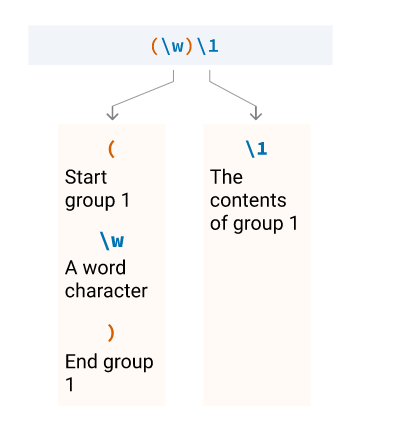

Let's see this in action using Python:

In [39]:
test_cases = [
              "I'm going to read a book.",
              "Green is my favorite color.",
              "My name is Aaron.",
              "No doubles here.",
              "I have a pet eel."
             ]

for tc in test_cases:
    print(re.search(r"(\w)\1", tc))

<re.Match object; span=(21, 23), match='oo'>
<re.Match object; span=(2, 4), match='ee'>
None
None
<re.Match object; span=(13, 15), match='ee'>


Notice that there was no match for the word Aaron, despite it containing a double "a." This is because the uppercase and lowercase "a" are two different characters, so the backreference does not match.

We can easily achieve the same thing using pandas:

In [40]:
test_cases = pd.Series(test_cases)
print(test_cases.str.contains(r"(\w)\1"))

0     True
1     True
2    False
3    False
4     True
dtype: bool


Let's use this technique to identify story titles that have repeated words.

In [42]:
pattern = r"\b(\w+)\s\1\b"

repeated_words = titles[titles.str.contains(pattern)]
repeated_words

3102                  Silicon Valley Has a Problem Problem
3176                Wire Wire: A West African Cyber Threat
3178                         Flexbox Cheatsheet Cheatsheet
4797                            The Mindset Mindset (2015)
7276     Valentine's Day Special: Bye Bye Tinder, Flirt...
10371    Mcdonalds copying cyriak  cows cows cows in th...
11575                                    Bang Bang Control
11901          Cordless Telephones: Bye Bye Privacy (1991)
12697          Solving the the Monty-Hall-Problem in Swift
15049    Bye Bye Webrtc2SIP: WebRTC with Asterisk and A...
15839          Intellij-Rust Rust Plugin for IntelliJ IDEA
Name: title, dtype: object

### Substituting regular expression matches

When we learned to work with basic string methods, we used the str.replace() method to replace simple substrings. We can achieve the same with regular expressions using the re.sub() function. The basic syntax for re.sub() is:

`re.sub(pattern, repl, string, flags=0)`

The repl parameter is the text that you would like to substitute for the match. Let's look at a simple example where we replace all capital letters in a string with dashes:

In [43]:
string = "aBcDEfGHIj"

print(re.sub(r"[A-Z]", "-", string))

a-c--f---j


When working in pandas, we can use the Series.str.replace() method, which uses nearly identical syntax:

`Series.str.replace(pat, repl, flags=0)`

Earlier, we discovered that there were multiple different capitalizations for SQL in our dataset. Let's look at how we could make these uniform with the Series.str.replace() method and a regular expression:

In [44]:
sql_variations = pd.Series(["SQL", "Sql", "sql"])

sql_uniform = sql_variations.str.replace(r"sql", "SQL", flags=re.I)
print(sql_uniform)

0    SQL
1    SQL
2    SQL
dtype: object


Let's use the same technique to make all the different variations of "email" in the dataset uniform.

In [47]:
email_variations = pd.Series(['email', 'Email', 'e Mail',
                        'e mail', 'E-mail', 'e-mail',
                        'eMail', 'E-Mail', 'EMAIL'])


pattern = r"\be[\s-]?mail"

email_uniform = email_variations.str.replace(pattern, 'email', flags = re.I)

<ipython-input-47-d91d8c0cdf52>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  email_uniform = email_variations.str.replace(pattern, 'email', flags = re.I)


In [46]:
titles_clean = titles.str.replace(pattern, 'email', flags = re.I)

<ipython-input-46-1e8f809b7f8d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  titles_clean = titles.str.replace(pattern, 'email', flags = re.I)


### Extracting domains from URLs

Over the final three screens in this mission, we'll extract components of URLs from our dataset. As a reminder, most stories on Hacker News contain a link to an external resource.

The task we will be performing first is extracting the different components of the URLs in order to analyze them. On this screen, we'll start by extracting just the domains. Below is a list of some of the URLs in the dataset, with the domains highlighted in color, so you can see the part of the string we want to capture.

![img](img/domain.pgn)

The domain of each URL excludes the protocol (e.g. https://) and the page path (e.g. /Technology-Ventures-Enterprise-Thomas-Byers/dp/0073523429).

There are several ways that you could use regular expressions to extract the domain, but we suggest the following technique:

- Using a series of characters that will match the protocol.
- Inside a capture group, using a set that will match the character classes used in the domain.
- Because all of the URLs either end with the domain, or continue with page path which starts with / (a character not found in any domains), we don't need to cater for this part of the URL in our regular expression.

Once you have extracted the domains, you will be building a frequency table so we can determine the most popular domains. There are over 7,000 unique domains in our dataset, so to make the frequency table easier to analyze, we'll look at only the top 20 domains.

We have provided some of the URLs from the dataset which will help you to iterate while you build your regular expression.

In [48]:
test_urls = pd.Series([
 'https://www.amazon.com/Technology-Ventures-Enterprise-Thomas-Byers/dp/0073523429',
 'http://www.interactivedynamicvideo.com/',
 'http://www.nytimes.com/2007/11/07/movies/07stein.html?_r=0',
 'http://evonomics.com/advertising-cannot-maintain-internet-heres-solution/',
 'HTTPS://github.com/keppel/pinn',
 'Http://phys.org/news/2015-09-scale-solar-youve.html',
 'https://iot.seeed.cc',
 'http://www.bfilipek.com/2016/04/custom-deleters-for-c-smart-pointers.html',
 'http://beta.crowdfireapp.com/?beta=agnipath',
 'https://www.valid.ly?param',
 'http://css-cursor.techstream.org'
])

pattern = r"https?://([\w\-\.]+)"

test_urls_clean = test_urls.str.extract(pattern, flags = re.I)
test_urls_clean

,0
0,www.amazon.com
1,www.interactivedynamicvideo.com
2,www.nytimes.com
3,evonomics.com
4,github.com
5,phys.org
6,iot.seeed.cc
7,www.bfilipek.com
8,beta.crowdfireapp.com
9,www.valid.ly


In [49]:
domains = hn['url'].str.extract(pattern, flags=re.I)

domains.value_counts().head(5)

github.com             1008
medium.com              825
www.nytimes.com         525
www.theguardian.com     248
techcrunch.com          245
dtype: int64

### Extracting URL parts using multiple capture groups

Having extracted just the domains from the URLs, on this final screen we'll extract each of the three component parts of the URLs:

1. Protocol
2. Domain
3. Page path

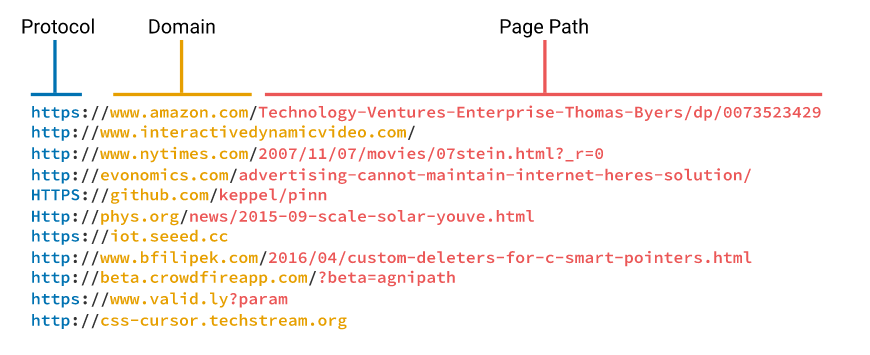

In order to do this, we'll create a regular expression with multiple capture groups. Multiple capture groups in regular expressions are defined the same way as single capture groups — using pairs of parentheses.

Let's look at how this works using the first few values from the created_at column in our dataset:

In [50]:
created_at = hn['created_at'].head()

print(created_at)

0     8/4/2016 11:52
1    6/23/2016 22:20
2     6/17/2016 0:01
3     9/30/2015 4:12
4    10/31/2015 9:48
Name: created_at, dtype: object


We'll use capture groups to extract these dates and times into two columns:

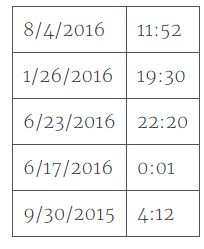

In order to do this we can write the following regular expression:

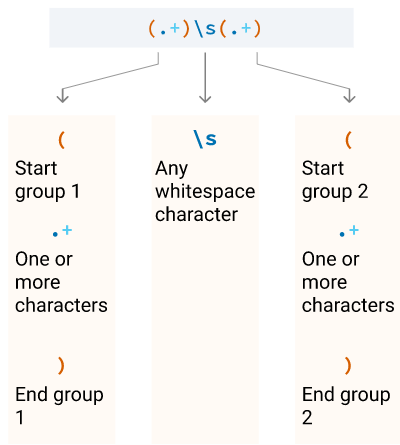

Notice how we put a space character between the capture groups, which matches the space character in the original strings.

Let's look at the result of using this regex pattern with Series.str.extract():

In [52]:
pattern = r"(.+)\s(.+)"
dates_times = created_at.str.extract(pattern)

dates_times

,0,1
0,8/4/2016,11:52
1,6/23/2016,22:20
2,6/17/2016,0:01
3,9/30/2015,4:12
4,10/31/2015,9:48


The result is a dataframe with each of our capture groups defining a column of data.

Now let's write a regular expression that will extract the URL components into individual columns of a dataframe

In [55]:
pattern = r"(https?)://([\w\.\-]+)(/?.*)"

test_url_parts = test_urls.str.extract(pattern, flags=re.I)
test_url_parts

,0,1,2
0,https,www.amazon.com,/Technology-Ventures-Enterprise-Thomas-Byers/d...
1,http,www.interactivedynamicvideo.com,/
2,http,www.nytimes.com,/2007/11/07/movies/07stein.html?_r=0
3,http,evonomics.com,/advertising-cannot-maintain-internet-heres-so...
4,HTTPS,github.com,/keppel/pinn
5,Http,phys.org,/news/2015-09-scale-solar-youve.html
6,https,iot.seeed.cc,
7,http,www.bfilipek.com,/2016/04/custom-deleters-for-c-smart-pointers....
8,http,beta.crowdfireapp.com,/?beta=agnipath
9,https,www.valid.ly,?param


In [54]:
url_parts = hn['url'].str.extract(pattern, flags=re.I)
url_parts

,0,1,2
0,http,www.interactivedynamicvideo.com,
1,http,www.thewire.com,entertainment/2013/04/florida-djs-april-fools-...
2,https,www.amazon.com,Technology-Ventures-Enterprise-Thomas-Byers/dp...
3,http,www.nytimes.com,2007/11/07/movies/07stein.html?_r=0
4,http,arstechnica.com,business/2015/10/comcast-and-other-isps-boost-...
...,...,...,...
20094,https,puri.sm,philosophy/how-purism-avoids-intels-active-man...
20095,https,medium.com,@zreitano/the-yc-application-broken-down-and-t...
20096,http,blog.darknedgy.net,technology/2016/01/01/0/
20097,https,medium.com,@benjiwheeler/how-product-hunt-really-works-d8...


### Using named capture groups to extract data

Our final task will be to name these columns, which we'll do using named capture groups. Let's look at the example from the previous screen where we used two capture groups to extract the date and time as two separate columns:

In [56]:
created_at = hn['created_at'].head()

pattern = r"(.+) (.+)"
dates_times = created_at.str.extract(pattern)
dates_times

,0,1
0,8/4/2016,11:52
1,6/23/2016,22:20
2,6/17/2016,0:01
3,9/30/2015,4:12
4,10/31/2015,9:48


In order to name a capture group we use the syntax `?P<name>`, where name is the name of our capture group. This syntax goes after the open parentheses, but before the regex syntax that defines the capture group:

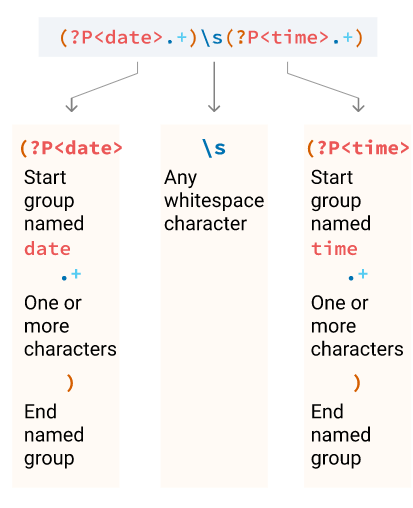

Let's look at the result of this syntax using pandas:

In [58]:
pattern = r"(?P<date>.+) (?P<time>.+)"

dates_times = created_at.str.extract(pattern)
dates_times

,date,time
0,8/4/2016,11:52
1,6/23/2016,22:20
2,6/17/2016,0:01
3,9/30/2015,4:12
4,10/31/2015,9:48


Each column has a name corresponding to the name of the capture group it represents.

Let's finish this mission by adding names to our capture group from the previous screen to create a dataframe with named columns.

In [59]:
pattern = r"(?P<protocol>https?)://(?P<domain>[\w\.\-]+)/?(?P<path>.*)"

url_parts = hn['url'].str.extract(pattern, flags = re.I)
url_parts

,protocol,domain,path
0,http,www.interactivedynamicvideo.com,
1,http,www.thewire.com,entertainment/2013/04/florida-djs-april-fools-...
2,https,www.amazon.com,Technology-Ventures-Enterprise-Thomas-Byers/dp...
3,http,www.nytimes.com,2007/11/07/movies/07stein.html?_r=0
4,http,arstechnica.com,business/2015/10/comcast-and-other-isps-boost-...
...,...,...,...
20094,https,puri.sm,philosophy/how-purism-avoids-intels-active-man...
20095,https,medium.com,@zreitano/the-yc-application-broken-down-and-t...
20096,http,blog.darknedgy.net,technology/2016/01/01/0/
20097,https,medium.com,@benjiwheeler/how-product-hunt-really-works-d8...
